In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset Preparation

In [2]:
data_path = "../data/"
data_file = data_path + "names.txt"

words = open(data_file, 'r').read().splitlines()

In [3]:
# Create a dictionary to map characters to indices ("string-to-index")
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i+1 for i, s in enumerate(chars)}

# Include a special character -  we use '.' instead of having both <S> and <E>
s_to_i['.'] = 0

# Create a dictionary to map indices to characters ("index-to-string")
i_to_s = {i: ch for ch, i in s_to_i.items()}

In [4]:
# Create training set of bigrams (x, y)
# Currently limited to just the first 5 characters, ".emma"

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [5]:
for i in range(5):
    print(i_to_s[xs[i].item()], i_to_s[ys[i].item()], xs[i].item(), ys[i].item())

. e 0 5
e m 5 13
m m 13 13
m a 13 1
a . 1 0


### One-hot Encodings

In [6]:
num_classes = len(s_to_i)

x_enc = F.one_hot(xs, num_classes=num_classes).float() # necessary to cast to float
y_enc = F.one_hot(ys, num_classes=num_classes).float()

In [7]:
print(x_enc.shape)
print(x_enc[:10])

torch.Size([5, 27])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


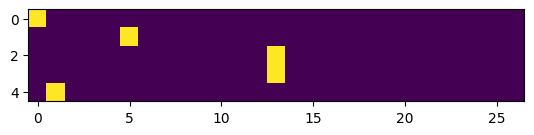

In [8]:
# A look at the first example, ".emma"
plt.imshow(x_enc)
plt.show()

### Logits

In [9]:
# Testing a multiplication with a weight matrix
W = torch.randn(num_classes, num_classes)
logits = x_enc @ W

# This should be 5x27:
# (5, 27) @ (27, 27) -> (5, 27)
print(logits.shape)
print(logits)

torch.Size([5, 27])
tensor([[ 1.5161,  0.2518, -0.8134, -1.5261,  0.0199,  1.3987, -0.6605,  1.5468,
         -1.4619,  1.3608,  0.1123, -0.7030, -0.0729, -0.3481,  0.4221, -0.3084,
         -0.0906, -0.2959, -0.4079,  0.3095,  0.5801, -1.3938,  0.0429, -0.8249,
          0.2482,  0.8125,  1.4743],
        [-1.4768,  1.0658, -0.0847,  0.4306, -0.1614, -1.6583,  0.5668,  0.1087,
         -0.5050,  0.5605,  1.4606, -0.0486,  0.4431, -0.8257,  1.6714,  0.3401,
         -1.4550, -0.0719,  0.2468, -0.2624,  1.0457, -1.1185,  1.2681, -1.4233,
          1.0308,  1.6871, -2.0817],
        [-3.6138, -1.1762,  0.0248, -0.9052,  0.0333,  0.2542, -1.3890,  0.1746,
         -1.8498, -1.1404, -0.5274,  2.2010, -0.5007, -0.2414, -0.0913, -0.1108,
         -0.4225, -0.2936,  0.4787, -1.0636,  1.2015,  0.7441, -0.3593, -2.7035,
          0.0993, -0.8035,  0.9771],
        [-3.6138, -1.1762,  0.0248, -0.9052,  0.0333,  0.2542, -1.3890,  0.1746,
         -1.8498, -1.1404, -0.5274,  2.2010, -0.5007, -0.24

In [10]:
# Looking at one logit
logits[3, 13] # 4th example, 14th class

tensor(-0.2414)

In [11]:
# Reminder that each such logit is a sum of the products of the one-hot 
# encoded input and the corresponding row of the weight matrix
print(x_enc[3] * W[:, 13])
print((x_enc[3] * W[:, 13]).sum())

tensor([-0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.2414,  0.0000,  0.0000,
         0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
         0.0000,  0.0000,  0.0000])
tensor(-0.2414)


### Softmax

In [12]:
# We can consider the logits here "log counts" of the bigrams
# We can see this more clearly by exponentiating the logits
# This makes all numbers positive

# This is equivalent to the N matrix from the statistical model notebook

counts = logits.exp()
counts

tensor([[4.5545, 1.2863, 0.4433, 0.2174, 1.0201, 4.0501, 0.5166, 4.6966, 0.2318,
         3.8992, 1.1189, 0.4951, 0.9297, 0.7061, 1.5252, 0.7346, 0.9134, 0.7439,
         0.6650, 1.3627, 1.7862, 0.2481, 1.0439, 0.4383, 1.2818, 2.2535, 4.3680],
        [0.2284, 2.9032, 0.9188, 1.5382, 0.8509, 0.1905, 1.7626, 1.1148, 0.6035,
         1.7516, 4.3085, 0.9526, 1.5576, 0.4379, 5.3195, 1.4051, 0.2334, 0.9306,
         1.2799, 0.7692, 2.8455, 0.3268, 3.5542, 0.2409, 2.8033, 5.4039, 0.1247],
        [0.0269, 0.3085, 1.0252, 0.4045, 1.0339, 1.2894, 0.2493, 1.1907, 0.1573,
         0.3197, 0.5901, 9.0343, 0.6061, 0.7856, 0.9128, 0.8952, 0.6554, 0.7455,
         1.6139, 0.3452, 3.3252, 2.1045, 0.6982, 0.0670, 1.1044, 0.4478, 2.6566],
        [0.0269, 0.3085, 1.0252, 0.4045, 1.0339, 1.2894, 0.2493, 1.1907, 0.1573,
         0.3197, 0.5901, 9.0343, 0.6061, 0.7856, 0.9128, 0.8952, 0.6554, 0.7455,
         1.6139, 0.3452, 3.3252, 2.1045, 0.6982, 0.0670, 1.1044, 0.4478, 2.6566],
        [0.0426, 0.3683,

In [13]:
# Converting the log counts to probabilities summing to 1
probs = counts / counts.sum(dim=1, keepdims=True)
probs

tensor([[0.1097, 0.0310, 0.0107, 0.0052, 0.0246, 0.0975, 0.0124, 0.1131, 0.0056,
         0.0939, 0.0269, 0.0119, 0.0224, 0.0170, 0.0367, 0.0177, 0.0220, 0.0179,
         0.0160, 0.0328, 0.0430, 0.0060, 0.0251, 0.0106, 0.0309, 0.0543, 0.1052],
        [0.0051, 0.0655, 0.0207, 0.0347, 0.0192, 0.0043, 0.0397, 0.0251, 0.0136,
         0.0395, 0.0971, 0.0215, 0.0351, 0.0099, 0.1199, 0.0317, 0.0053, 0.0210,
         0.0289, 0.0173, 0.0642, 0.0074, 0.0801, 0.0054, 0.0632, 0.1218, 0.0028],
        [0.0008, 0.0095, 0.0315, 0.0124, 0.0317, 0.0396, 0.0076, 0.0365, 0.0048,
         0.0098, 0.0181, 0.2772, 0.0186, 0.0241, 0.0280, 0.0275, 0.0201, 0.0229,
         0.0495, 0.0106, 0.1020, 0.0646, 0.0214, 0.0021, 0.0339, 0.0137, 0.0815],
        [0.0008, 0.0095, 0.0315, 0.0124, 0.0317, 0.0396, 0.0076, 0.0365, 0.0048,
         0.0098, 0.0181, 0.2772, 0.0186, 0.0241, 0.0280, 0.0275, 0.0201, 0.0229,
         0.0495, 0.0106, 0.1020, 0.0646, 0.0214, 0.0021, 0.0339, 0.0137, 0.0815],
        [0.0014, 0.0121,

## Summary So Far

In [14]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(num_classes, num_classes, generator=g)

x_enc = F.one_hot(xs, num_classes=num_classes).float() # input to the network: one-hot encodings
y_enc = F.one_hot(ys, num_classes=num_classes).float()

In [15]:
# Calculate the logits for all bigrams
logits = x_enc @ W # predict log-counts

# Softmax
counts = torch.exp(logits) # counts, equivalent to N
probs = counts / counts.sum(dim=1, keepdims=True) # probabilities for next character

In [16]:
# examining ".emma"
# Note high nll when the model assigns low likelihood to the correct character

nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------')
    print(f'bigram example {i+1}: {i_to_s[x]}{i_to_s[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

## Training the Network

In [17]:
x_enc = F.one_hot(xs, num_classes=num_classes).float()
y_enc = F.one_hot(ys, num_classes=num_classes).float()

g = torch.Generator().manual_seed(2147483647)
W = torch.randn(num_classes, num_classes, generator=g, requires_grad=True)

In [18]:
# To evaluate training, we can look at the probabilities of the characters we want to predict
# In this case, we look at y for each character in .emma

probs[torch.arange(5), ys]

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150])

In [19]:
# Negative average log likelihood for this example:
-probs[torch.arange(5), ys].log().mean()

tensor(3.7693)

In [20]:
# Forward pass

logits = x_enc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
loss = -probs[torch.arange(len(ys)), ys].log().mean()   

In [21]:
# Backward pass
W.grad = None # how to set gradient to zero in PyTorch
loss.backward()

In [22]:
# Update
W.data += -0.1 * W.grad

In [23]:
# Do another forward pass with the new data and compare with the previous loss
print(loss.item())

logits = x_enc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
loss = -probs[torch.arange(len(ys)), ys].log().mean()   

print(loss.item())

3.7693049907684326
3.7492127418518066


Can then perform another backward pass, etc.

## Training With a Training Loop

In [24]:
# Hyperparameters

num_steps = 100
learning_rate = 50 # seems a large one works fine for this task
reg_coefficient = 0.01 # regularization coefficient; high is like adding more counts to smoothing

# Create full-size training set of bigrams (x, y)

xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = s_to_i[ch1]
        ix2 = s_to_i[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

x_enc = F.one_hot(xs, num_classes=num_classes).float()
y_enc = F.one_hot(ys, num_classes=num_classes).float()

# Randomly initialize the weight matrix

g = torch.Generator().manual_seed(2147483647)
W = torch.randn(num_classes, num_classes, generator=g, requires_grad=True)

# Keep track of data for plotting
losses = []

# Training loop
for i in range(num_steps):
    # Forward pass
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    # Regularization
    loss += reg_coefficient * (W ** 2).mean()
    losses.append(loss.item())
    print(f'step {i}: loss = {loss.item()}')

    # Backward pass
    W.grad = None
    loss.backward()

    # Update
    W.data += -learning_rate * W.grad

step 0: loss = 3.7686190605163574
step 1: loss = 3.3788068294525146
step 2: loss = 3.161090850830078
step 3: loss = 3.027186155319214
step 4: loss = 2.9344842433929443
step 5: loss = 2.8672313690185547
step 6: loss = 2.816654682159424
step 7: loss = 2.777146577835083
step 8: loss = 2.745253801345825
step 9: loss = 2.7188303470611572
step 10: loss = 2.6965057849884033
step 11: loss = 2.6773719787597656
step 12: loss = 2.6608052253723145
step 13: loss = 2.6463515758514404
step 14: loss = 2.633665084838867
step 15: loss = 2.622471570968628
step 16: loss = 2.6125476360321045
step 17: loss = 2.6037068367004395
step 18: loss = 2.595794916152954
step 19: loss = 2.5886809825897217
step 20: loss = 2.582256317138672
step 21: loss = 2.5764293670654297
step 22: loss = 2.5711238384246826
step 23: loss = 2.566272735595703
step 24: loss = 2.5618226528167725
step 25: loss = 2.5577263832092285
step 26: loss = 2.5539445877075195
step 27: loss = 2.550442695617676
step 28: loss = 2.5471925735473633
step 2

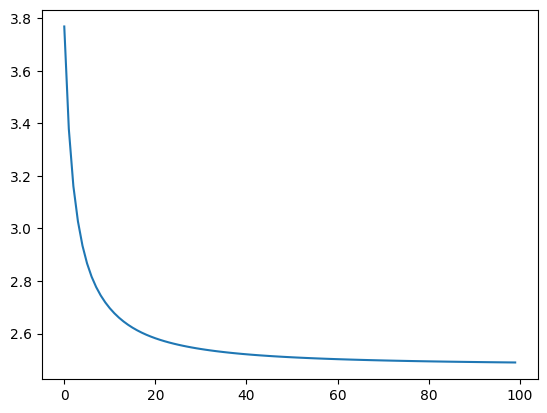

In [25]:
# Plot loss
plt.plot(losses)
plt.show()

## Sampling from the Neural Network

In [26]:
g = torch.Generator().manual_seed(2147483647)


for i in range(5):
    out = []
    ix = 0
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=num_classes).float()
        logits = x_enc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(i_to_s[ix])
        if ix == 0:
            break

    print(''.join(out))

junide.
janasah.
p.
cfay.
a.
